In [67]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [29]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-22 22:02:24--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M  --.-KB/s    in 0.1s    

2023-10-22 22:02:25 (12.6 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [43]:
df = pd.read_csv('housing.csv')
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [44]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])].reset_index(drop=True)

In [45]:
# view NaNs
display(df.isnull().any())
print()
display(df.isnull().sum())

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [46]:
# fill NaNs 
df = df.fillna(0)

In [47]:
# split 60/20/20 
x_full_train, x_test = train_test_split(df, test_size=0.2, random_state=1)
x_train, x_val = train_test_split(x_full_train, test_size=0.2, random_state=1)

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

y_train = np.log1p(x_train.median_house_value.values)
y_val = np.log1p(x_val.median_house_value.values)
y_test = np.log1p(x_test.median_house_value.values)

x_train = x_train.drop(columns='median_house_value')
x_val = x_val.drop(columns='median_house_value')
x_test = x_test.drop(columns='median_house_value')

In [53]:
list(x_train.columns)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [81]:
cols = list(x_train.columns)

dv = DictVectorizer(sparse=True)

train_dict = x_train[cols].to_dict(orient='records')
df_train = dv.fit_transform(train_dict)

val_dict = x_val[cols].to_dict(orient='records')
df_val = dv.transform(val_dict)

### Question 1

In [60]:
from sklearn.tree import DecisionTreeRegressor, export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(df_train, y_train)

dt.get_params(deep = True)


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [61]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



### Question 2

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rf.fit(df_train, y_train)

y_pred = rf.predict(df_val)
print('RSME: {}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

RSME: 0.2391873286927073


### Question 3 

  0%|          | 0/20 [00:00<?, ?it/s]

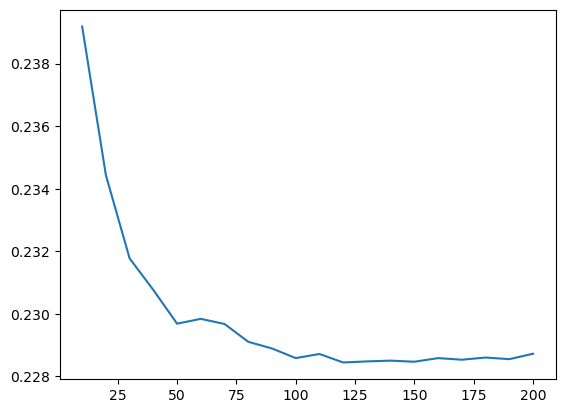

In [83]:
# from collections import defaultdict 

# d = defaultdict(int)

scores = []

for n in tqdm(range(10,210,10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=1)
    rf.fit(df_train, y_train)
    
    y_pred = rf.predict(df_val)
    err = np.sqrt(mean_squared_error(y_val, y_pred))
    
#     d[n] = err
    scores.append((n,err))
    
    
q3 = pd.DataFrame(scores, columns=['n_estimators', 'rsme'])    
plt.plot(q3['n_estimators'], q3['rsme'])

In [86]:
for n, rsme in scores:
    print(n, np.round(rsme, 3)) # 50 

10 0.239
20 0.234
30 0.232
40 0.231
50 0.23
60 0.23
70 0.23
80 0.229
90 0.229
100 0.229
110 0.229
120 0.228
130 0.228
140 0.229
150 0.228
160 0.229
170 0.229
180 0.229
190 0.229
200 0.229


### Question 4

In [87]:
max_depth = [10, 15, 20, 25]
scores2 = []

for d in tqdm(max_depth):
    
    rf = RandomForestRegressor(n_estimators=0, max_depth=d, random_state=1, n_jobs=1, warm_start=True)
    
    for n in tqdm(range(10,210,10)):
        
        # warm_start to increase the n_estimators
        rf.n_estimators = n 
        rf.fit(df_train, y_train)

        y_pred = rf.predict(df_val)
        err = np.sqrt(mean_squared_error(y_val, y_pred))
    
        scores2.append((d,n,err))
        
q4 = pd.DataFrame(scores2, columns=['depth', 'n_estimators', 'rsme'])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [89]:
q4

,depth,n_estimators,rsme
0,10,10,0.246376
1,10,20,0.242630
2,10,30,0.242025
3,10,40,0.240886
4,10,50,0.240022
...,...,...,...
75,25,160,0.228621
76,25,170,0.228569
77,25,180,0.228654
78,25,190,0.228599


In [94]:
q4['rmse_round'] = np.round(q4['rsme'], 3)

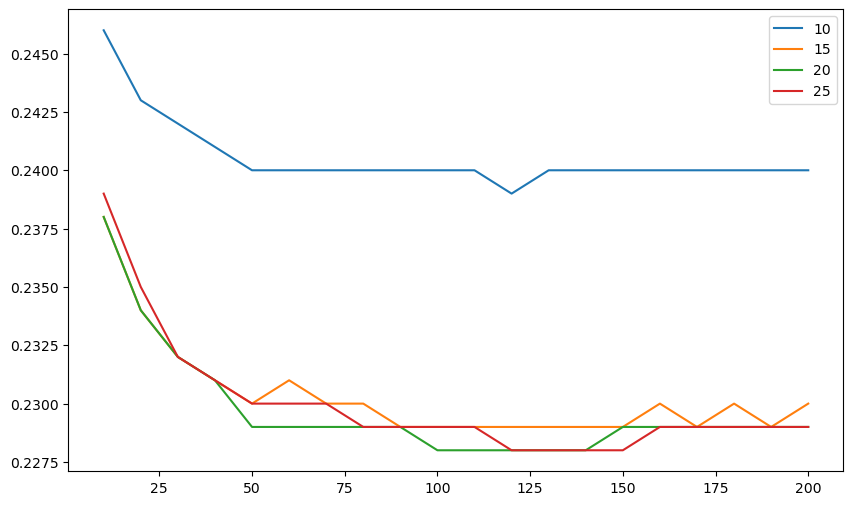

In [95]:
plt.figure(figsize=(10,6))

for d in max_depth:
    df_subset = q4[q4.depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse_round, label=d)

plt.legend()
plt.show();

In [107]:
q4[(q4['depth'] == 20) | (q4['depth'] == 25)]

,depth,n_estimators,rsme,rmse_round
40,20,10,0.238070,0.238
41,20,20,0.234156,0.234
42,20,30,0.232131,0.232
43,20,40,0.230569,0.231
44,20,50,0.229367,0.229
45,20,60,0.229477,0.229
46,20,70,0.229433,0.229
47,20,80,0.228788,0.229
48,20,90,0.228546,0.229
49,20,100,0.228362,0.228


In [113]:
display(q4[(q4['depth'] == 20)].rsme)
print()
display(q4[(q4['depth'] == 25)].rsme)

40    0.238070
41    0.234156
42    0.232131
43    0.230569
44    0.229367
45    0.229477
46    0.229433
47    0.228788
48    0.228546
49    0.228362
50    0.228431
51    0.228313
52    0.228425
53    0.228474
54    0.228509
55    0.228710
56    0.228735
57    0.228813
58    0.228718
59    0.228881
Name: rsme, dtype: float64

60    0.239290
61    0.234513
62    0.231824
63    0.230691
64    0.229558
65    0.229666
66    0.229666
67    0.229220
68    0.228766
69    0.228524
70    0.228567
71    0.228434
72    0.228378
73    0.228391
74    0.228442
75    0.228621
76    0.228569
77    0.228654
78    0.228599
79    0.228776
Name: rsme, dtype: float64

### Question 5

In [115]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=1)
rf.fit(df_train, y_train)
rf.feature_importances_

array([0.01558704, 0.03198149, 0.10065676, 0.09093335, 0.33453038,
       0.32881959, 0.03677885, 0.02643465, 0.01467482, 0.01960309])

In [121]:
feats = []
for f, i in zip(dv.feature_names_, rf.feature_importances_):
    feats.append((f,i))

q5 = pd.DataFrame(feats, columns=['feature', 'importance'])
q5.sort_values(by=['importance'], ascending=False)

,feature,importance
4,median_income,0.334530
5,ocean_proximity=<1H OCEAN,0.328820
2,latitude,0.100657
3,longitude,0.090933
6,ocean_proximity=INLAND,0.036779
1,housing_median_age,0.031981
7,population,0.026435
9,total_rooms,0.019603
0,households,0.015587
8,total_bedrooms,0.014675


In [123]:
# !pip install xgboost # dont have this because of the reinstall

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/01/11/4840ff80f77a393ac929197b27335873c056e24e20231df97523786bcbf8/xgboost-2.0.0-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.4 MB/s eta 0:00:0000:0100:01


In [124]:
import xgboost as xgb

In [133]:
features = dv.feature_names_
features = [f.replace('=<','_').replace('=', '_').replace(' ', '_').lower() for f in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity_1h_ocean',
 'ocean_proximity_inland',
 'population',
 'total_bedrooms',
 'total_rooms']

In [138]:
dtrain = xgb.DMatrix(df_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(df_val, label=y_val, feature_names=features)

In [143]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [144]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [145]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
        
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  evals=watchlist,
                  verbose_eval=5 )

In [146]:
scores['eta=0.3'] = parse_xgb_output(output)

In [147]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
        
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, 
                  evals=watchlist,
                  verbose_eval=5 )

In [148]:
scores['eta=0.1'] = parse_xgb_output(output)

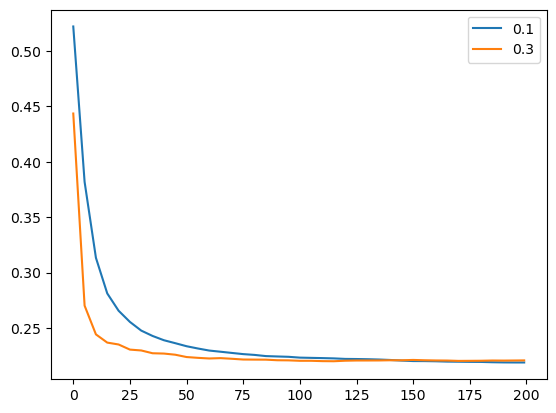

In [150]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show();